In [14]:
# start step-by step
from skimage import io, feature, filters
import skimage
from skimage.morphology import disk 
from skimage.external import tifffile # io for tif-files
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy.ndimage as scp # for 3D features and filters

from sklearn.externals import joblib # to save and load the classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

In [3]:
# some constants 
sigmas=[2, 4] # defines how many gaussian rings you take

In [5]:
# extended to 3D feature generation 
def generate_features3D(image, sigma):
    # generate range of sigmas
    sigmas = range(sigma[0], sigma[1] + 1)
    
    f_values = image.flatten() 
    f_sobel = scp.sobel(image).flatten()
    
    f_gauss = np.zeros([len(image.flatten()), len(sigmas)])
    f_dog = np.zeros([len(image.flatten()), len(sigmas) - 1])
    f_gabor = np.zeros([len(image.flatten()), len(sigmas)])
    
    idx = 0
    for s in range(sigma[0], sigma[1] + 1):
        # consider only Re part for gabor filter
        f_gauss[:, idx] = scp.gaussian_filter(image, s).flatten()
        if (idx != 0):
            f_dog[:, idx - 1] = f_gauss[:, idx] - f_gauss[:, idx - 1]
        idx += 1
    
    f_max = scp.maximum_filter(image, sigma[0]).flatten()
    f_median = scp.median_filter(image, sigma[0]).flatten() # run median only with the minimal sigma
    f_laplacian = scp.laplace(image).flatten()
    
    # full set of features
    f_set = np.vstack([f_values, f_max, 
                       f_median, f_sobel, 
                       f_gauss.T, f_dog.T,
                       f_laplacian]).T
    return f_set
    

In [6]:
# read the raw data and the binary classification (test data)
# raw = io.imread('data/raw-3D.tif')
# cells = io.imread('data/binary-3D.tif')
raw = io.imread('data/raw-49.tif')
cells = io.imread('data/binary-49.tif')
bg = np.invert(cells)

raw data size: (555, 380)
cells data size: (555, 380)


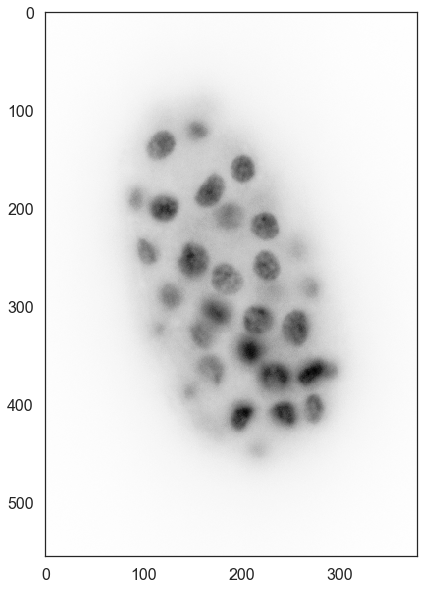

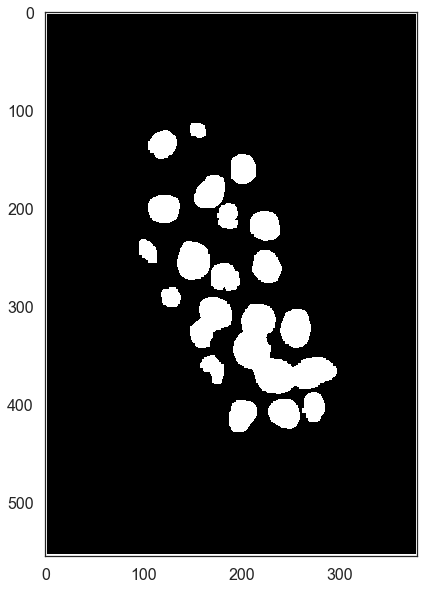

In [7]:
# some feedback
print("raw data size:" , raw.shape)
plt.figure(figsize=(20,10))
plt.imshow(raw[:, :])

print("cells data size:", cells.shape)
plt.figure(figsize=(20,10))
plt.imshow(cells[:, :])

# print(bg.shape)
# plt.figure(figsize=(20,10))
# plt.imshow(bg)

In [8]:
# check which values correspond to cells
cells[cells == 255] = 1
np.unique(cells)

array([0, 1], dtype=uint8)

In [9]:
y = cells.flatten()
X = generate_features3D(raw, sigmas)
print("# of generated features: ", X.shape[1])


# of generated features:  10


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X.shape, X_train.shape, X_test.shape

((210900, 10), (141303, 10), (69597, 10))

In [17]:
skf = StratifiedKFold(y, 5)
precision_scores = list()
recall_scores = list()
aucs = list()
for train_ix, test_ix in skf: # for each of K folds
    # define training and test sets
    X_train, X_test = X[train_ix,:], X[test_ix,:]
    y_train, y_test = y[train_ix], y[test_ix]
    
    # Train classifier
    clf = RandomForestClassifier(n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Predict test set labels
    yhat = clf.predict(X_test)
    yprob = clf.predict_proba(X_test)
    
    # Calculate metrics
    aucs.append(roc_auc_score(y_test, yprob[:,1]))
    precision_scores.append(precision_score(y_test, yhat))
    recall_scores.append(recall_score(y_test, yhat))

In [18]:
# save the classifier to the file 
# sys.setrecursionlimit(10000) # but you might need this one
joblib.dump(clf, "data/clf.pkl", compress=9)

['data/clf.pkl']

In [19]:
# restore the classifier from the file
clf = joblib.load('data/clf.pkl')

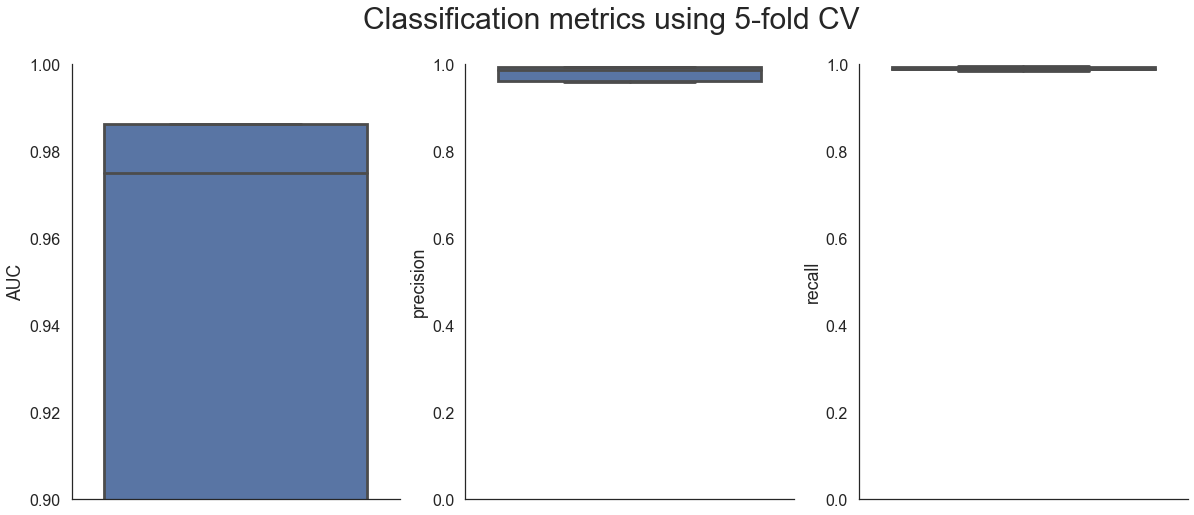

In [32]:
plt.figure(figsize=(20,8))
plt.subplot(131)
sns.boxplot(aucs, orient='v')
plt.ylim(.9,1)
plt.ylabel("AUC")

plt.subplot(132)
sns.boxplot(precision_scores, orient='v')
plt.ylim(0,1)
plt.ylabel("precision")

plt.subplot(133)
sns.boxplot(recall_scores, orient='v')
plt.ylim(0,1)
plt.ylabel("recall")
sns.despine()

plt.suptitle("Classification metrics using 5-fold CV", fontsize=30)

In [20]:
# prepare run on the real data
raw_real = io.imread('data/raw-85.tif')

# calculate the features manually
X_real = generate_features3D(raw_real, sigmas);

raw_real_predicted = clf.predict(X_real)
raw_real_predicted_proba = clf.predict_proba(X_real)

NameError: name 'imsave' is not defined

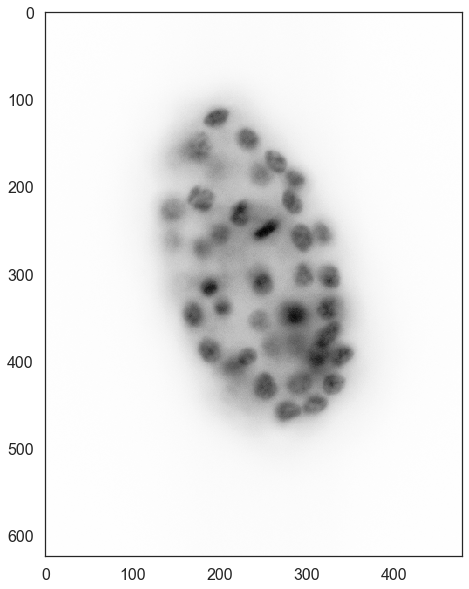

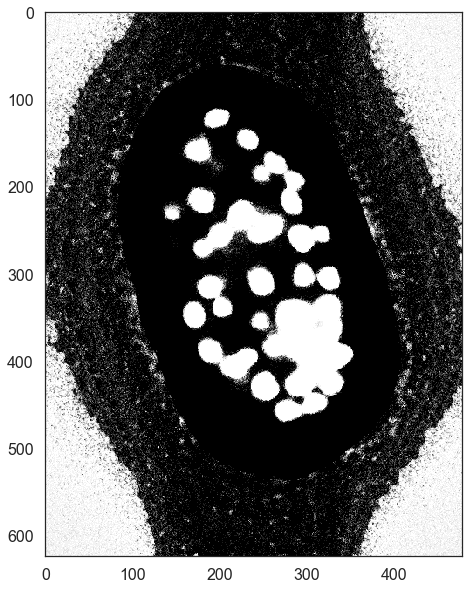

In [24]:
result = np.reshape(raw_real_predicted, raw_real.shape)
result_proba = np.reshape(raw_real_predicted_proba[:, 1], raw_real.shape)
# show image to classify
plt.figure(figsize=(20,10))
plt.imshow(raw_real)
# probability map 
plt.figure(figsize=(20,10))
plt.imshow(result_proba)

tifffile.imsave('data/raw.tif', raw_real)
tifffile.imsave('data/proba.tif', result_proba)

# plt.figure(figsize=(20,10))
# plt.imshow(result)